<a href="https://colab.research.google.com/github/gatewj/Stop_Sign_Identification/blob/main/model_one_withPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Computer Vision (Project)
### IBM AI Engineering Course (Coursera)

## Project Scenario
You have been employed as a Junior Data Scientist by Jokwu, a self-driving car start-up in Capetown, South Africa. Jokwu has created the hardware and parts of the car, and they are beginning to create sensors; the next step is to have a working model that identifies traffic signs. **The project and product team have decided to start with stop signs - is it a stop sign or not?**

**First step**, you have been given a dataset and tasked with training a model that identifies the stop signs in an image. This will be integrated into a motion detector as a next step.

## Project Tasks
Your job is to load the training images, create features, and train the model. You will then deploy the model to Code Engine so your manager can upload an image of a stop sign and your image classifier will classify the image and tell them to what accuracy it predicts it is correct.

1.   Gather and upload data
2.   Train the classifier
3.   Deploy the Model


In [1]:
# Running this cell will provide you with a token to link your drive to this notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Library for OS
#-----------------
import os
import uuid
import shutil
import json
import copy
from datetime import datetime

In [3]:
# Libraries for Data Processing and Visualization
#------------------------------------------------
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib.pyplot import imshow
from tqdm import tqdm
from ipywidgets import IntProgress
import time 

In [4]:
# Deep Learning Libraries
#------------------------
import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)

In [5]:
# Plot train cost and validation accuracy:
#-----------------------------------------
def plot_stuff(COST,ACC):    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()

In [6]:
# Plot the transformed image:
#----------------------------
def imshow_(inp, title=None):
    """Imshow for Tensor."""
    inp = inp .permute(1, 2, 0).numpy() 
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  
    plt.show()

In [7]:
# Compare the prediction and actual value:
def result(model,x,y):
    #x,y=sample
    z=model(x.unsqueeze_(0))
    _,yhat=torch.max(z.data, 1)
    
    if yhat.item()!=y:
        text="predicted: {} actual: {}".format(str(yhat.item()),y)
        print(text)

In [8]:
# Define our device as the first visible cuda device if we have CUDA available:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)

the device type is cpu


## Load Data

In this section we will preprocess our dataset by changing the shape of the image, converting to tensor and normalizing the image channels. These are the default preprocessing steps for image data. In addition, we will perform data augmentation on the training dataset. The preprocessing steps for the test dataset is the same, but we do not perform data augmentation on the test dataset.

mean = [0.485, 0.456, 0.406]

std = [0.229, 0.224, 0.225]

composed = transforms.Compose([transforms.Resize((224, 224)),<br>
           transforms.RandomHorizontalFlip(),transforms.RandomRotation(degrees=5) <br>, transforms.ToTensor() <br>, transforms.Normalize(mean, std)])

In [9]:
mean = [0.485, 0.456, 0.406]

std = [0.229, 0.224, 0.225]

composed = transforms.Compose([transforms.Resize((224, 224)),
transforms.RandomHorizontalFlip(),transforms.RandomRotation(degrees=5)
, transforms.ToTensor()
, transforms.Normalize(mean, std)])

valid_size = 0.8


dataset = datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/IBM PyTorch/final_model/images_dir/', transform=composed)


n_train = int(np.floor(valid_size * len(dataset)))
n_val = len(dataset) - n_train


In [10]:
len(dataset.classes)

2

In [11]:
train_ds, val_ds = random_split(dataset, [n_train, n_val])

train_set = DataLoader(train_ds, batch_size=32, shuffle=True)
val_set = DataLoader(val_ds, batch_size=32, shuffle=True)

In [12]:
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [13]:
#len(train_set)

In [14]:
!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py

--2022-05-31 01:09:28--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2022-05-31 01:09:28 (24.4 MB/s) - ‘helper.py’ saved [2813/2813]



In [15]:
import helper

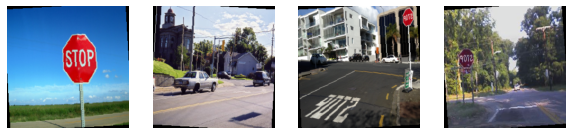

In [16]:
data_iter = iter(train_set)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
  ax = axes[ii]
  helper.imshow(images[ii], ax=ax, normalize=True)
  #plt.show()

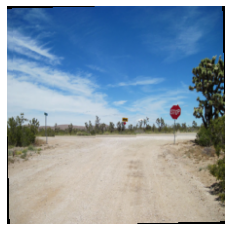

In [17]:
images, labels = next(iter(train_set))
helper.imshow(images[0], normalize=True)
plt.show()

## Hyperparameters

In [18]:
# Epoch indicates the number of passes of the entire training dataset, here we will set the number of epochs to 10:
n_epochs = 10

# Batch size is the number of training samples utilized in one iteration. If the batch size is equal to the total number of samples in the training set, then every epoch has one iteration. In Stochastic Gradient Descent, the batch size is set to one. A batch size of 32--512 data points seems like a good value, for more information check out the following link.
batch_size = 32

# Learning rate is used in the training of neural networks. Learning rate is a hyperparameter with a small positive value, often in the range between 0.0 and 1.0.
lr=0.000001

# Momentum is a term used in the gradient descent algorithm to improve training results:
momentum=0.9

# If you set to lr_scheduler=True for every epoch use a learning rate scheduler changes the range of the learning rate from a maximum or minimum value. The learning rate usually decays over time.
lr_scheduler=True
base_lr=0.001
max_lr=0.01

## Load Model and Train

In [19]:
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs,print_=True):
    loss_list = []
    accuracy_list = []
    correct = 0
    #global:val_set
    n_test = len(val_set)
    accuracy_best=0
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
        # Loop through the data in loader
    print("The first epoch should take several minutes")
    for epoch in tqdm(range(n_epochs)):
        
        loss_sublist = []
        # Loop through the data in loader

        for x, y in train_loader:
            x, y=x.to(device), y.to(device)
            model.train() 

            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()

            optimizer.zero_grad()
        print("epoch {} done".format(epoch) )

        scheduler.step()    
        loss_list.append(np.mean(loss_sublist))
        correct = 0


        for x_test, y_test in validation_loader:
            x_test, y_test=x_test.to(device), y_test.to(device)
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
        if accuracy>accuracy_best:
            accuracy_best=accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        
        
        if print_:
            print('learning rate',optimizer.param_groups[0]['lr'])
            print("The validaion  Cost for each epoch " + str(epoch + 1) + ": " + str(np.mean(loss_sublist)))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy)) 
    model.load_state_dict(best_model_wts)    
    return accuracy_list,loss_list, model

Load the pre-trained model resnet18. Set the parameter pretrained to true.

In [20]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

We will only train the last layer of the network set the parameter requires_grad to False, the network is a fixed feature extractor.

In [21]:
for param in model.parameters():
        param.requires_grad = False

Number of classes

In [22]:
n_classes=dataset.classes
n_classes

['not_stop', 'stop']

In [23]:
# Type your code here
model.fc = nn.Linear(512, 2)

In [24]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
criterion = nn.CrossEntropyLoss()

In [26]:
train_loader = torch.utils.data.DataLoader(dataset=train_set , batch_size=batch_size,shuffle=True)
validation_loader= torch.utils.data.DataLoader(dataset=val_set , batch_size=1)

In [27]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [28]:
if lr_scheduler:
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01,step_size_up=5,mode="triangular2")

In [29]:
start_datetime = datetime.now()
start_time=time.time()

accuracy_list,loss_list, model=train_model(model, train_set , val_set, criterion, optimizer, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("elapsed time", elapsed_time )

The first epoch should take several minutes


  0%|          | 0/10 [00:00<?, ?it/s]

epoch 0 done


 10%|█         | 1/10 [00:55<08:16, 55.20s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 1: 0.7494024395942688
The validation accuracy for epoch 1: 8.5
epoch 1 done


 20%|██        | 2/10 [01:16<04:39, 34.99s/it]

learning rate 0.0046
The validaion  Cost for each epoch 2: 0.629623007774353
The validation accuracy for epoch 2: 14.0
epoch 2 done


 30%|███       | 3/10 [01:36<03:19, 28.47s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 3: 0.44476076364517214
The validation accuracy for epoch 3: 17.5
epoch 3 done


 40%|████      | 4/10 [01:57<02:32, 25.42s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 4: 0.2947553038597107
The validation accuracy for epoch 4: 17.5
epoch 4 done


 50%|█████     | 5/10 [02:18<01:58, 23.75s/it]

learning rate 0.010000000000000002
The validaion  Cost for each epoch 5: 0.2348900854587555
The validation accuracy for epoch 5: 18.5
epoch 5 done


 60%|██████    | 6/10 [02:39<01:31, 22.76s/it]

learning rate 0.008199999999999999
The validaion  Cost for each epoch 6: 0.29121308624744413
The validation accuracy for epoch 6: 13.5
epoch 6 done


 70%|███████   | 7/10 [02:59<01:06, 22.12s/it]

learning rate 0.006400000000000001
The validaion  Cost for each epoch 7: 0.4031839221715927
The validation accuracy for epoch 7: 18.5
epoch 7 done


 80%|████████  | 8/10 [03:20<00:43, 21.73s/it]

learning rate 0.0046
The validaion  Cost for each epoch 8: 0.2883262038230896
The validation accuracy for epoch 8: 18.0
epoch 8 done


 90%|█████████ | 9/10 [03:41<00:21, 21.42s/it]

learning rate 0.002800000000000002
The validaion  Cost for each epoch 9: 0.18892232030630113
The validation accuracy for epoch 9: 18.5
epoch 9 done


100%|██████████| 10/10 [04:02<00:00, 24.24s/it]

learning rate 0.001
The validaion  Cost for each epoch 10: 0.21666343212127687
The validation accuracy for epoch 10: 18.5
elapsed time 242.4224989414215


In [30]:
parameters = {
    'epochs': n_epochs,
    'learningRate': lr,
    'momentum':momentum,
   # 'percentage used training':percentage_train,
    "learningRatescheduler": {"lr_scheduler":lr_scheduler,"base_lr":base_lr, "max_lr" :max_lr}
}

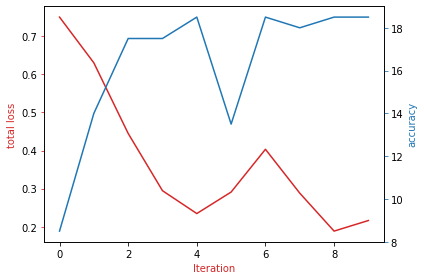

In [31]:
plot_stuff(loss_list,accuracy_list)

In [32]:
#model_scripted = torch.jit.script(model) # Export to TorchScript
#model_scripted.save('/content/drive/MyDrive/Colab Notebooks/IBM PyTorch/final_model/model_scripted2.pt')

In [33]:
# References
# https://stackoverflow.com/questions/68982798/loading-dating-without-a-separate-train-test-directory-pytorch-imagefolder
# https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7
# https://medium.com/secure-and-private-ai-writing-challenge/loading-image-using-pytorch-c2e2dcce6ef2